In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rna_transform.utils as utils
import rna_transform.rna_utils as rna_utils
from qspright.utils import dec_to_qary_vec
import itertools

In [2]:
# import os
# import ipyparallel as ipp
# import time

# # mycluster = ipp.Cluster(n = int(os.getenv('SLURM_CPUS_ON_NODE')))
# # mycluster.start_cluster_sync()

# # c = mycluster.connect_client_sync()
# # c.wait_for_engines(n = int(os.getenv('SLURM_CPUS_ON_NODE')))
# # c.ids

# # dview = c[:]
# # # Cause execution on main process to wait while tasks sent to workers finish
# # dview.block = True   

# cluster = ipp.Cluster()
# await cluster.start_controller()
# engine_set_id = await cluster.start_engines(n=4)
# rc = await cluster.connect_client()
# rc.wait_for_engines(4)
# rc.ids
# dview = rc[:]

In [3]:
q = 4
positions = rna_utils.RNA_POSITIONS

# positions = positions[:8]
# rna_utils.RNA_POSITIONS = positions

n = len(positions)

print("n = {}, N = {}".format(n, q ** n))

n = 4, N = 256


## calculate RNA free energies

In [4]:
rna_utils.calculate_rna_data(parallel=True)

Calculating free energies...


100%|██████████| 256/256 [00:00<00:00, 3871.81it/s]


### get Lasso coefficients

In [5]:
# emp_beta_lasso = rna_utils.calculate_rna_lasso(save=True)

In [6]:
# Calculate fraction of variance explained by empirical coefficients
# bm_fv_lasso = utils.calc_frac_var_explained(emp_beta_lasso)

### get GWHT coefficients

In [7]:
emp_beta_gwht = rna_utils.calculate_rna_gwht(save=False)

Found GWHT coefficients


In [8]:
# Calculate fraction of variance explained by empirical coefficients
bm_fv_gwht = utils.calc_frac_var_explained(emp_beta_gwht)

### get GWHT coefficients with QSPRIGHT

In [9]:
num_subsample = 2
num_random_delays = 10
b = 6
gwht, (n_used, n_used_unique), peeled = rna_utils.calculate_rna_qspright(save=False, report = True,  noise_sd = 100 / (q ** n), num_subsample = num_subsample, num_random_delays = num_random_delays, b = b)
emp_beta_qspright = np.reshape(gwht, -1)
print("total sample ratio = ", n_used / q ** n)
print("unique sample ratio = ", n_used_unique / q ** n)
print("found sparsity = ", np.sum(np.abs(emp_beta_qspright) > 1e-5))
print("NMSE = ", np.sum(np.abs(emp_beta_gwht - emp_beta_qspright)**2) / np.sum(np.abs(emp_beta_gwht)**2))

total sample ratio =  1600.0
unique sample ratio =  1.0
found sparsity =  19
NMSE =  0.015719137038830724


In [10]:
# Calculate fraction of variance explained by empirical coefficients
bm_fv_qspright = utils.calc_frac_var_explained(emp_beta_qspright)

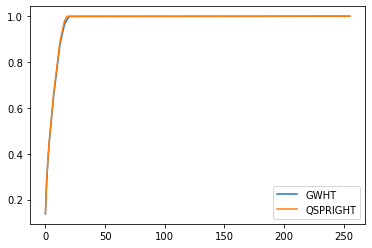

In [11]:
# plt.plot(bm_fv_lasso[:300], label = "Fourier")
plt.plot(bm_fv_gwht, label = "GWHT")
plt.plot(bm_fv_qspright, label = "QSPRIGHT")
plt.legend()
plt.show()

### get one-hot WHT coefficients

In [12]:
beta_onehot = rna_utils.calculate_rna_onehot_wht(save=False)

Found one-hot WHT coefficients


In [13]:
# Calculate fraction of variance explained by empirical coefficients
bm_fv_onehot = utils.calc_frac_var_explained(beta_onehot)

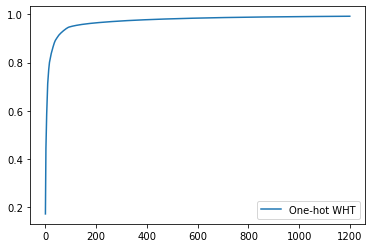

In [14]:
plt.plot(bm_fv_onehot[:1200], label = "One-hot WHT")
plt.legend()
plt.show()

### get WHT coefficients with one-hot SPRIGHT (default SPRIGHT)

In [15]:
num_subsample = 2
num_random_delays = 10
b = 6
wht, (n_used, n_used_unique), peeled = rna_utils.calculate_rna_onehot_spright(save=False, report = True,  noise_sd = 200 / (2 ** (q * n)), num_subsample = num_subsample, num_random_delays = num_random_delays, b = 12)
beta_onehot_spright = np.reshape(wht, -1)

print("total sample ratio = ", n_used / 2 ** (q*n))
print("unique sample ratio = ", n_used_unique / 2 ** (q * n))
print("found sparsity = ", np.sum(np.abs(beta_onehot_spright) > 1e-5))
print("NMSE = ", np.sum(np.abs(beta_onehot - beta_onehot_spright)**2) / np.sum(np.abs(beta_onehot)**2))

total sample ratio =  21.25
unique sample ratio =  1.0
found sparsity =  66
NMSE =  0.07457747816875354


In [16]:
# Calculate fraction of variance explained
bm_fv_onehot_spright = utils.calc_frac_var_explained(beta_onehot_spright)

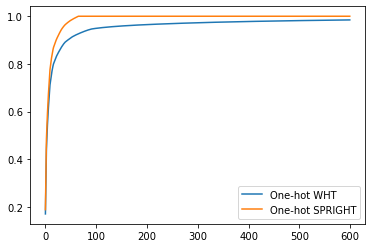

In [17]:
plt.plot(bm_fv_onehot[:600], label = "One-hot WHT")
plt.plot(bm_fv_onehot_spright[:600], label = "One-hot SPRIGHT")
plt.legend()
plt.show()

### run parallel tests with different parameters

In [18]:
iters = 10
num_subsample_list = [2, 3, 4]
num_random_delays_list = [3, 5, 7]
b_list = [4, 5, 6]
test_params_list = list(itertools.product(num_subsample_list, num_random_delays_list, b_list))

def gwht_test(i):
    param_idx = i % len(test_params_list)
    test_params = test_params_list[param_idx]
    num_subsample, num_random_delays, b = test_params
    gwht, (n_used, n_used_unique), peeled = calculate_rna_qspright(save=False, report = True, num_subsample = num_subsample, num_random_delays = num_random_delays, b = b)
    emp_beta_qspright = np.reshape(gwht, -1)
    sample_ratio = n_used / q ** n
    unique_sample_ratio = n_used_unique/ q ** n
    nmse = np.sum(np.abs(emp_beta_gwht - emp_beta_qspright)**2) / np.sum(np.abs(emp_beta_gwht)**2)
    return param_idx, sample_ratio, unique_sample_ratio, nmse

In [19]:
dview.execute('import numpy as np')
dview.execute('import sys')
dview.execute('sys.path.append("src")')
dview.execute('sys.path.append(".")')
dview.execute('sys.path.append("../src/qspright")')

mydict = dict(test_params_list = test_params_list, calculate_rna_qspright = calculate_rna_qspright, gwht_test = gwht_test, q=q, n=n, emp_beta_gwht = emp_beta_gwht)
dview.push(mydict)

NameError: name 'dview' is not defined

In [ ]:
def test_wrapper(i):
    return gwht_test(i) 

In [ ]:
exp_count = iters * len(test_params_list)

time.time()
# Run a parallel map, executing the wrapper function on indices 0,...,n-1
lview = c.load_balanced_view()
# Cause execution on main process to wait while tasks sent to workers finish
lview.block = True 
pred = lview.map(test_wrapper, range(exp_count))   # Run calculation in parallel
time.time()

In [ ]:
test_params_idx_list = list(itertools.product(np.arange(len(num_subsample_list)), np.arange(len(num_random_delays_list)), np.arange(len(b_list))))

sample_ratios = np.zeros((len(num_subsample_list), len(num_random_delays_list), len(b_list), iters))
unique_sample_ratios = np.zeros((len(num_subsample_list), len(num_random_delays_list), len(b_list), iters))
nmses = np.zeros((len(num_subsample_list), len(num_random_delays_list), len(b_list), iters))

for i, exp_result in enumerate(pred):
    iter_idx = i // len(test_params_list)
    test_params_idx = i % len(test_params_list)
    test_params_idx = test_params_idx_list[test_params_idx]
    param_idx, sample_ratio, unique_sample_ratio, nmse = exp_result
    idx = test_params_idx + (iter_idx,)
    sample_ratios[idx] = sample_ratio
    unique_sample_ratios[idx] = unique_sample_ratio
    nmses[idx] = nmse

In [ ]:
for i, b in enumerate(b_list):
    s_values = np.mean(unique_sample_ratios[:, :, i, :], axis=-1).flatten()
    mse_values =  np.mean(nmses[:, :, i, :], axis=-1).flatten()

    plt.scatter(s_values, mse_values, label = "b = {}".format(b))

plt.xlabel('Unique Sample Ratio')
plt.ylabel('NMSE')
plt.legend()
plt.show()

In [ ]:
for i, b in enumerate(b_list):
    s_values = np.mean(sample_ratios[:, :, i, :], axis=-1).flatten()
    mse_values =  np.mean(nmses[:, :, i, :], axis=-1).flatten()

    plt.scatter(s_values, mse_values, label = "b = {}".format(b))

plt.xlabel('Total Sample Ratio')
plt.ylabel('NMSE')
plt.legend()
plt.show()

### compare indices with most energy

In [ ]:
beta_power = np.abs(emp_beta_gwht) ** 2
for _ in range(30):
    ind = beta_power.argmax()
    print(beta_power[ind], np.array(dec_to_qary_vec([ind], n = n, q=q))[:, 0])
    beta_power[ind] = 0

In [ ]:
beta_power = np.abs(emp_beta_qspright) ** 2
for _ in range(30):
    ind = beta_power.argmax()
    print(beta_power[ind], np.array(dec_to_qary_vec([ind], n = n, q=q))[:, 0])
    beta_power[ind] = 0